#Beam Element - This notebook computes the mass-matrix and body-forces for later use


1. 2D beam generalized coordinates (1 rotation 2 displacements) (Reduced dimensions so all matricies are subsequently invertible, Mii = 0 if some dof's are accounted for but  unused)
2. Interpolation of roataion matricies WITHOUT orthogonalization (sympy struggling with too much algebra)
3. Square(?) cross-section with dimension 'r'

In [1]:
import numpy as np
import scipy as sp
import sympy as sym
import pickle

from scipy import linalg
from sympy import mpmath
from sympy import cos, sin
from sympy import lambdify

from IPython.display import display
from __future__ import division
from sympy.interactive import printing
printing.init_printing(use_latex='mathjax')
np.set_printoptions(precision=4,suppress=True)

import matplotlib.pyplot as plt
%matplotlib inline

#### Define Needed Functions

In [2]:
def Skew_sym(v):
    """
    This function returns the skew symetric matrix 
    of the vector 'v' to affect the cross product of 'v'x'u'
    """
    v_matrix = sym.Matrix([[  0 , -v[2]],
                          [v[2],     0]])
    return v_matrix

In [3]:
def Axial_sym(A):
    '''
    This funtcion returns the vector of the skew-symmectric matrix in 2D
    '''
    a_vec = 1/2*sym.Matrix([A[1,0] - A[0,1]])
    return a_vec

In [4]:
def Rotate_sym(theta):
    """
    This function returns the symbolic rotation matrix 
    for the simple 2D-rotation about the third axis
    """
    R = sym.Matrix([[cos(theta),-sin(theta)],
                    [sin(theta), cos(theta)]])
    return R

#### Define symbolic quantites

In [5]:
# symbolic system parameters 
E, G, I, A, rho, x, l, r, g, pi = sym.symbols('E G I A rho x l r g pi')

# Kinematic values of previos nodes (generic)
# e.g., omega_node  = omega + qdot
theta = sym.Matrix(['theta_1','theta_2'])
theta_dot = sym.Matrix(['thetadot_1','thetadot_2'])
theta_ddot = sym.Matrix(['thetaddot_1','thetaddot_2'])
omega = sym.Matrix(['omega_1','omega_2'])
alpha = sym.Matrix(['alpha_1','alpha_2'])

# coordinates of the point in the 2D cross-section
# of nodes one and two 
s1 = sym.Matrix(['r_2','r_3'])
s2 = sym.Matrix(['r_2','r_3'])
s = sym.Matrix.vstack(s1,s2)

# generalized coordinates
# one rotation and two displacements per-node (two nodes per element)
# in this version generalzied speeds are qdots
q = sym.Matrix(sym.symarray('q',6))
qdot = sym.Matrix(sym.symarray('qdot',len(q)))
qddot = sym.Matrix(sym.symarray('qddot',len(q)))

# Deformations of Nodes (u's are not generalized speeds) 
u = sym.Matrix([q[1:3,0], q[4:6,0]])
udot = sym.Matrix([qdot[1:3,0], qdot[4:8,0]])
uddot = sym.Matrix([qddot[1:3,0], qddot[4:6,0]])

# display([q,qdot,qddot])
# display([u,udot,uddot])

### Needed Matrix Quantities

In [6]:
# Kinematics of the 2D planar SINGLE element
theta[0] = q[0]
theta[1] = q[0] + q[3]
theta_dot[0] = qdot[0]
theta_dot[1] = qdot[0] + qdot[3]
theta_ddot[0] = qddot[0]
theta_ddot[1] = qddot[0] + qddot[3]

# Rotation Matricies for each node
R1 = Rotate_sym(theta[0])
R2 = Rotate_sym(theta[1])

# Angular Velocities and Accelerations are trivial for the 2D case
# For each node
omega1_skew = Skew_sym([0,0,theta_dot[0]])
omega2_skew = Skew_sym([0,0,theta_dot[1]])
alpha1_skew = Skew_sym([0,0,theta_ddot[0]])
alpha2_skew = Skew_sym([0,0,theta_ddot[1]])


# "elemental" rotation matrix
R = sym.Matrix.vstack(sym.Matrix.hstack(R1,sym.zeros(2)), \
                      sym.Matrix.hstack(sym.zeros(2),R2))

# "elemental" angular velocity matrix
Omega_skew = sym.Matrix.vstack(sym.Matrix.hstack(omega1_skew,sym.zeros(2)), \
                               sym.Matrix.hstack(sym.zeros(2),omega2_skew))

# "elemental" angular acceleration matrix
Alpha_skew = sym.Matrix.vstack(sym.Matrix.hstack(alpha1_skew,sym.zeros(2)), \
                               sym.Matrix.hstack(sym.zeros(2),alpha2_skew))

### Define Kinematics

In [7]:
# Define velocity of element endpoints (nodes)
v = sym.simplify(udot + R*Omega_skew*s)
print('v = ')
display(v)

# Define acceleration of element endpoints (nodes)
a = sym.simplify(uddot + R*Omega_skew*Omega_skew*s + R*Alpha_skew*s)
print('\na = ')
display(a)

v = 


⎡            -q̇₀⋅r₂⋅sin(q₀) - q̇₀⋅r₃⋅cos(q₀) + q̇₁             ⎤
⎢                                                               ⎥
⎢             q̇₀⋅r₂⋅cos(q₀) - q̇₀⋅r₃⋅sin(q₀) + q̇₂             ⎥
⎢                                                               ⎥
⎢q̇₄ - r₂⋅(q̇₀ + q̇₃)⋅sin(q₀ + q₃) - r₃⋅(q̇₀ + q̇₃)⋅cos(q₀ + q₃)⎥
⎢                                                               ⎥
⎣q̇₅ + r₂⋅(q̇₀ + q̇₃)⋅cos(q₀ + q₃) - r₃⋅(q̇₀ + q̇₃)⋅sin(q₀ + q₃)⎦


a = 


⎡                                                                     2       
⎢                         -q̈₀⋅r₂⋅sin(q₀) - q̈₀⋅r₃⋅cos(q₀) + q̈₁ - q̇₀ ⋅r₂⋅cos
⎢                                                                             
⎢                                                                     2       
⎢                          q̈₀⋅r₂⋅cos(q₀) - q̈₀⋅r₃⋅sin(q₀) + q̈₂ - q̇₀ ⋅r₂⋅sin
⎢                                                                             
⎢                                                  2                          
⎢q̈₄ - r₂⋅(q̈₀ + q̈₃)⋅sin(q₀ + q₃) - r₂⋅(q̇₀ + q̇₃) ⋅cos(q₀ + q₃) - r₃⋅(q̈₀ + 
⎢                                                                             
⎢                                                  2                          
⎣q̈₅ + r₂⋅(q̈₀ + q̈₃)⋅cos(q₀ + q₃) - r₂⋅(q̇₀ + q̇₃) ⋅sin(q₀ + q₃) - r₃⋅(q̈₀ + 

          2                                     ⎤
(q₀) + q̇₀ ⋅r₃⋅sin(q₀)                          ⎥
                              

### Compute the Mass Matrix

In [80]:
# Define shape function for element with one node at each end
h = sym.symarray('h', 2)

h[0] = sym.Rational(1,2)*(1 - x)
h[1] = sym.Rational(1,2)*(1 + x)

# Compute shape function matrix
H = sym.Matrix([h[0]*sym.eye(2), h[1]*sym.eye(2)]).T
dHdx = H.diff(x)
print('\nH = ')
display(H)

# Define position of any point 
# Rp = H*rp
# print('\nR = ')
# display(Rp)

# Define velocity of any point 
Vp = H*v
print('\nV = ')
display(Vp)

# Define velocity of any point 
Ap = H*a
# print('\nA = ')
# display(Accel)

# Compute partial velocities of the nodes
Vr = sym.simplify(sym.Matrix([[sym.diff(Vp,qdot) for Vp in Vp] for qdot in qdot]).T)
print('\nVr = ')
display(Vr)
# print(Vr.shape)

# Compute mass matrix
M = pi*rho*sym.simplify(sym.Matrix(
        [[sym.expand(sym.integrate(Vr[:,i].dot(Ap),('r_2',0,r),('r_3',0,r),(x,0,l))).coeff(qddot[j]) 
          for i in range(len(qddot))] for j in range(len(qddot))]))


H = 


⎡  x   1           x   1       ⎤
⎢- ─ + ─     0     ─ + ─    0  ⎥
⎢  2   2           2   2       ⎥
⎢                              ⎥
⎢           x   1         x   1⎥
⎢   0     - ─ + ─    0    ─ + ─⎥
⎣           2   2         2   2⎦


V = 


⎡⎛  x   1⎞                                            ⎛x   1⎞                 
⎢⎜- ─ + ─⎟⋅(-q̇₀⋅r₂⋅sin(q₀) - q̇₀⋅r₃⋅cos(q₀) + q̇₁) + ⎜─ + ─⎟⋅(q̇₄ - r₂⋅(q̇₀ +
⎢⎝  2   2⎠                                            ⎝2   2⎠                 
⎢                                                                             
⎢⎛  x   1⎞                                           ⎛x   1⎞                  
⎢⎜- ─ + ─⎟⋅(q̇₀⋅r₂⋅cos(q₀) - q̇₀⋅r₃⋅sin(q₀) + q̇₂) + ⎜─ + ─⎟⋅(q̇₅ + r₂⋅(q̇₀ + 
⎣⎝  2   2⎠                                           ⎝2   2⎠                  

                                                 ⎤
 q̇₃)⋅sin(q₀ + q₃) - r₃⋅(q̇₀ + q̇₃)⋅cos(q₀ + q₃))⎥
                                                 ⎥
                                                 ⎥
                                                 ⎥
q̇₃)⋅cos(q₀ + q₃) - r₃⋅(q̇₀ + q̇₃)⋅sin(q₀ + q₃)) ⎥
                                                 ⎦


Vr = 


⎡(x - 1)⋅(r₂⋅sin(q₀) + r₃⋅cos(q₀))   (x + 1)⋅(r₂⋅sin(q₀ + q₃) + r₃⋅cos(q₀ + q₃
⎢───────────────────────────────── - ─────────────────────────────────────────
⎢                2                                        2                   
⎢                                                                             
⎢(-x + 1)⋅(r₂⋅cos(q₀) - r₃⋅sin(q₀))   (x + 1)⋅(r₂⋅cos(q₀ + q₃) - r₃⋅sin(q₀ + q
⎢────────────────────────────────── + ────────────────────────────────────────
⎣                2                                         2                  

))     x   1           -(x + 1)⋅(r₂⋅sin(q₀ + q₃) + r₃⋅cos(q₀ + q₃))   x   1   
──   - ─ + ─     0     ─────────────────────────────────────────────  ─ + ─   
       2   2                                 2                        2   2   
                                                                              
₃))             x   1   (x + 1)⋅(r₂⋅cos(q₀ + q₃) - r₃⋅sin(q₀ + q₃))          x
───     0     - ─ + ─   ───────────────────────────

In [81]:
# print('\nM = \n')
# display(M)

print('M_11 = ')
display(M[0:3,0:3])
print('\nM_22 = ')
display(M[3:6,3:6])
print('\nM_12 = ')
display(M[0:3,3:6])
print('\nM_21.T = ')
display(M[3:6,0:3].T)

M_11 = 


⎡                                                                             
⎢                                      4   ⎛   2            2                ⎞
⎢                                 l⋅π⋅r ⋅ρ⋅⎝- l ⋅cos(q₃) + l  + 3⋅cos(q₃) + 3⎠
⎢                                 ────────────────────────────────────────────
⎢                                                      9                      
⎢                                                                             
⎢  ___      3   ⎛   2    ⎛     π⎞    2    ⎛          π⎞          ⎛     π⎞     
⎢╲╱ 2 ⋅l⋅π⋅r ⋅ρ⋅⎜- l ⋅sin⎜q₀ + ─⎟ + l ⋅sin⎜q₀ + q₃ + ─⎟ + 3⋅l⋅sin⎜q₀ + ─⎟ - 3⋅
⎢               ⎝        ⎝     4⎠         ⎝          4⎠          ⎝     4⎠     
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                                      24                     
⎢                                                                             
⎢   ___      3   ⎛ 2    ⎛     π⎞    2    ⎛          


M_22 = 


⎡                                                     ___      3   ⎛ 2        
⎢                 4   ⎛ 2          ⎞               -╲╱ 2 ⋅l⋅π⋅r ⋅ρ⋅⎝l  + 3⋅l +
⎢            l⋅π⋅r ⋅ρ⋅⎝l  + 3⋅l + 3⎠                                          
⎢            ───────────────────────               ───────────────────────────
⎢                       18                                                24  
⎢                                                                             
⎢   ___      3   ⎛ 2          ⎞    ⎛          π⎞                              
⎢-╲╱ 2 ⋅l⋅π⋅r ⋅ρ⋅⎝l  + 3⋅l + 3⎠⋅sin⎜q₀ + q₃ + ─⎟                    2   ⎛ 2   
⎢                                  ⎝          4⎠               l⋅π⋅r ⋅ρ⋅⎝l  + 
⎢────────────────────────────────────────────────              ───────────────
⎢                       24                                                12  
⎢                                                                             
⎢   ___      3   ⎛ 2          ⎞    ⎛          π⎞    


M_12 = 


⎡                                                      ___      3   ⎛ 2    ⎛  
⎢     4   ⎛   2            2                      ⎞  ╲╱ 2 ⋅l⋅π⋅r ⋅ρ⋅⎜l ⋅sin⎜q₀
⎢l⋅π⋅r ⋅ρ⋅⎝- l ⋅cos(q₃) + l  + 3⋅l + 3⋅cos(q₃) + 3⎠                 ⎝      ⎝  
⎢──────────────────────────────────────────────────  ─────────────────────────
⎢                        18                                                   
⎢                                                                             
⎢       ___      3   ⎛ 2    ⎞    ⎛          π⎞                                
⎢     ╲╱ 2 ⋅l⋅π⋅r ⋅ρ⋅⎝l  - 3⎠⋅sin⎜q₀ + q₃ + ─⎟                                
⎢                                ⎝          4⎠                                
⎢     ────────────────────────────────────────                                
⎢                        24                                                   
⎢                                                                             
⎢      ___      3   ⎛   2    ⎞    ⎛          π⎞     


M_21.T = 


⎡                                                      ___      3   ⎛ 2    ⎛  
⎢     4   ⎛   2            2                      ⎞  ╲╱ 2 ⋅l⋅π⋅r ⋅ρ⋅⎜l ⋅sin⎜q₀
⎢l⋅π⋅r ⋅ρ⋅⎝- l ⋅cos(q₃) + l  + 3⋅l + 3⋅cos(q₃) + 3⎠                 ⎝      ⎝  
⎢──────────────────────────────────────────────────  ─────────────────────────
⎢                        18                                                   
⎢                                                                             
⎢       ___      3   ⎛ 2    ⎞    ⎛          π⎞                                
⎢     ╲╱ 2 ⋅l⋅π⋅r ⋅ρ⋅⎝l  - 3⎠⋅sin⎜q₀ + q₃ + ─⎟                                
⎢                                ⎝          4⎠                                
⎢     ────────────────────────────────────────                                
⎢                        24                                                   
⎢                                                                             
⎢      ___      3   ⎛   2    ⎞    ⎛          π⎞     

In [82]:
# sym.simplify()

### Compute Internal forces 

#### 1. Transverse (Bending) Strain

In [12]:
# Orthogonal Matricies Not Extracted to Simplify Algebra
R_interp = sym.simplify(H*sym.Matrix([R1,R2]))
dT = sym.simplify(H.diff(x)*sym.Matrix([R1,R2]))
kappa = sym.simplify(sym.Matrix([Axial_sym(dT*R_interp.T),'0','0','0']))
# display(kappa)

In [13]:
R_interp

⎡(-x + 1)⋅cos(q₀)   (x + 1)⋅cos(q₀ + q₃)  (x - 1)⋅sin(q₀)   (x + 1)⋅sin(q₀ + q
⎢──────────────── + ────────────────────  ─────────────── - ──────────────────
⎢       2                    2                   2                   2        
⎢                                                                             
⎢(-x + 1)⋅sin(q₀)   (x + 1)⋅sin(q₀ + q₃)  (-x + 1)⋅cos(q₀)   (x + 1)⋅cos(q₀ + 
⎢──────────────── + ────────────────────  ──────────────── + ─────────────────
⎣       2                    2                   2                    2       

₃) ⎤
── ⎥
   ⎥
   ⎥
q₃)⎥
───⎥
   ⎦

#### 2. Longitudinal (Axial) Strian

In [14]:
# Define Locations of Centroid
x0_B = sym.Matrix(['x','0'])
x0 = R_interp*x0_B

# Define Newtonian Unit Vector x-dir
n1 = sym.Matrix(['1','0'])

# Interpolate Displacemnts
u_terp = H*u

# Derivatives w.r.t longitudinal beam coordinate
du = u_terp.diff(x)
dx0 = x0.diff(x)

# Compute axial strain
u_ax = (dx0 + du - R_interp*n1).simplify()
epsilon = sym.Matrix(['0', u_ax[0], '0', u_ax[1]])
# epsilon = u_ax
display(epsilon)

⎡                  0                   ⎤
⎢                                      ⎥
⎢  q₁   q₄   x⋅(cos(q₀) - cos(q₀ + q₃))⎥
⎢- ── + ── - ──────────────────────────⎥
⎢  2    2                2             ⎥
⎢                                      ⎥
⎢                  0                   ⎥
⎢                                      ⎥
⎢  q₂   q₅   x⋅(sin(q₀) - sin(q₀ + q₃))⎥
⎢- ── + ── - ──────────────────────────⎥
⎣  2    2                2             ⎦

#### 3. Compute Internal Forces $Q_e = -\frac{\partial U}{\partial e}$

In [15]:
"""
Note: Sympy bug! Integrating a matrix returns a vector!!!
"""
# Transverse strain energy
kappa_squared = (kappa.T*dHdx.T).dot(dHdx*kappa)
Ut = 1/2*sym.integrate(E*I*kappa_squared, (x,0,l))

In [16]:
G = E/2.6
C = sym.Matrix([[E*A, 0],[0, 5/6*G*A]])
Ul = 1/2*sym.integrate(epsilon.T*dHdx.T*R_interp*C*R_interp.T*dHdx*epsilon, (x,0,l))[0]
# Ul = 1/2*sym.integrate(epsilon.T*R_interp*C*R_interp.T*epsilon, (x,0,l))[0]

In [17]:
# Compute Total Energy
U = Ul + Ut

# Compute Internal Force Vector
Qe = sym.Matrix([-sym.diff(U,qi) for qi in q])

####4. Applied and body force vector

In [18]:
# Applied forces
# Gravity body force
fg = g*rho*sym.Matrix([0,-1])

# Compute beta
beta = sym.Matrix([sym.simplify(sym.integrate(Vr[:,j].dot(fg),('r_2',0,r),('r_3',0,r),(x,0,l)))
                   + qe for j,qe in zip(range(len(q)),Qe)])
Fg = sym.Matrix([sym.simplify(sym.integrate(Vr[:,j].dot(fg),('r_2',0,r),('r_3',0,r),(x,0,l)))
                   for j in range(len(q))])

In [25]:
pickle.dump( M,    open( "gebf-mass-matrix.dump",   "wb" ) )
pickle.dump( beta, open( "gebf-force-vector.dump",  "wb" ) )
pickle.dump( U,    open( "gebf-strain-energy.dump", "wb" ) )
# pickle.dump(PE, open("potential_enrgy", "wb")) 

In [26]:
M_func    = lambdify((E, A, I, r, rho, l, g, pi, q),    M, "numpy")
beta_func = lambdify((E, A, I, r, rho, l, g, pi, q), beta, "numpy")
U_func    = lambdify((E, A, I, r, rho, l, g, pi, q),    U, "numpy")

In [27]:
# Debugging functions to trace source of error 
Qe_func    = lambdify((E, A, I, r, rho, l, g, pi, q),    Qe, "numpy")
Fg_func    = lambdify((E, A, I, r, rho, l, g, pi, q),    Fg, "numpy")
Ut_func    = lambdify((E, A, I, r, rho, l, g, pi, q),    Ut, "numpy")
Ul_func    = lambdify((E, A, I, r, rho, l, g, pi, q),    Ul, "numpy")
# e2_func    = lambdify((E, A, I, r, rho, l, g, q), epsilon_squared, "numpy")

In [29]:
beta_num = beta_func(0.7e6, 0.0018, 1.215e-8, 0.02393, 5540, 0.12, 9.81, np.pi, np.zeros_like(q))
M_num    = M_func(   0.7e6, 0.0018, 1.215e-8, 0.02393, 5540, 0.12, 9.81, np.pi, np.zeros_like(q))
U_num    = U_func(   0.7e6, 0.0018, 1.215e-8, 0.02393, 5540, 0.12, 9.81, np.pi, np.zeros_like(q))

In [36]:
def zeta_func(q):
    M_num    = M_func(   0.7e6, 0.0018, 1.215e-8, 0.02393, 5540, 0.12, 9.81, np.pi, q)
    M11 = np.array(M_num[0:3,0:3])
    M12 = np.array(M_num[0:3,3:6])
    M21 = np.array(M_num[3:6,0:3])
    M22 = np.array(M_num[3:6,3:6])

    # For now use these definitions to cast Fic (constraint forces between GEBF elements) 
    # into generalized constraint forces
    gamma11 = np.eye(3)
    gamma12 = np.zeros((3,3))
    gamma22 = np.eye(3)
    gamma21 = np.zeros((3,3))

    # partition beta into lambda13 and lambda23
    gamma13 = np.array(beta_num[0:3])
    gamma23 = np.array(beta_num[3:6])

    # Commonly inverted quantities
    iM11 = np.linalg.inv(M11)
    iM22 = np.linalg.inv(M22)
    Gamma1 = np.linalg.inv(M11 - M12.dot(iM22.dot(M21)))
    Gamma2 = np.linalg.inv(M22 - M21.dot(iM11.dot(M12)))

    # Compute all terms of the two handle equations
    z11 = Gamma1.dot(gamma11 - M12.dot(iM22.dot(gamma21)))
    z12 = Gamma1.dot(gamma12 - M12.dot(iM22.dot(gamma22)))
    z21 = Gamma2.dot(gamma21 - M21.dot(iM11.dot(gamma11)))
    z22 = Gamma2.dot(gamma22 - M21.dot(iM11.dot(gamma12)))

    z13 = Gamma1.dot(gamma13 - M12.dot(iM22.dot(gamma23))).reshape((3,1))
    z23 = Gamma2.dot(gamma23 - M21.dot(iM11.dot(gamma13))).reshape((3,1))
    return M22

In [58]:
theta = np.linspace(0,2*np.pi,200)                                                                 

q0GEBF = [np.array([theta,0,0,0,0,0]).reshape(6,1) for theta in theta]
# Ul_theta = np.array([Ul_func(0.7e6, 0.0018, 1.215e-8, 0.02393, 5540, 0.12, 9.81, q0) for q0 in q0GEBF])
# Ut_theta = np.array([Ut_func(0.7e6, 0.0018, 1.215e-8, 0.02393, 5540, 0.12, 9.81, q0) for q0 in q0GEBF])
# Qe_theta = np.array([np.linalg.norm(Qe_func(0.7e6, 0.0018, 1.215e-8, 0.02393, 5540, 0.12, 9.81, q0)) for q0 in q0GEBF])                                                                   
# Fg_theta = np.array([np.linalg.norm(Fg_func(0.7e6, 0.0018, 1.215e-8, 0.02393, 5540, 0.12, 9.81, q0)) for q0 in q0GEBF])                                                                   
zeta_theta = np.array([np.linalg.cond(zeta_func(q0)) for q0 in q0GEBF])
# M_norm = np.array([np.linalg.norm(M_func(0.7e6, 0.0018, 1.215e-8, 0.02393, 5540, 0.12, 9.81, q0)) for q0 in q0GEBF])
M_theta = np.array([M_func(0.7e6, 0.0018, 1.215e-8, 0.02393, 5540, 0.12, 9.81, np.pi, q0) for q0 in q0GEBF])


In [59]:
# plt.plot(theta/np.pi, Ul_theta, '-g')
# plt.show()

In [60]:
# plt.plot(theta/np.pi, Ut_theta, '-g')
# plt.show()

In [61]:
# plt.plot(theta/np.pi, Qe_theta, '-g')
# plt.show()

In [62]:
# ax = plt.gca()
# ax.ticklabel_format(useOffset=False)
# plt.semilogy(theta/np.pi, zeta_theta, '-r')
# plt.show()

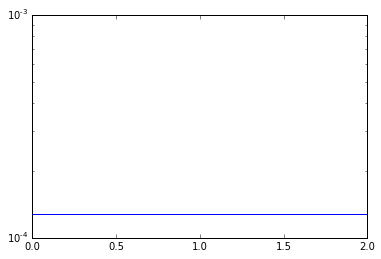

In [72]:
ax = plt.gca()
ax.ticklabel_format(useOffset=False)
plt.semilogy(theta/np.pi, M_theta[:,3,3])
plt.show()

In [51]:
M_num = M_func(   0.7e6, 0.0018, 1.215e-8, 0.02393, 5540, 0.12, 9.81, np.pi, q0GEBF[90])

In [52]:
M_num

matrix([[ 0.0005,  0.0044, -0.0084,  0.0002,  0.005 , -0.0095],
        [ 0.0044,  0.2646,  0.    ,  0.0023,  0.2976,  0.    ],
        [-0.0084,  0.    ,  0.2646, -0.0045,  0.    ,  0.2976],
        [ 0.0002,  0.0023, -0.0045,  0.0001,  0.0027, -0.005 ],
        [ 0.005 ,  0.2976,  0.    ,  0.0027,  0.3363,  0.    ],
        [-0.0095,  0.    ,  0.2976, -0.005 ,  0.    ,  0.3363]])

In [56]:
sym.integrate(pi, ('r_2',0,r), ('r_3',0,r))

   2
π⋅r 

In [55]:
M[0:3,0:3].subs([(rho,5540),(l,0.12),(r,0.02393),(pi,np.pi), (q[0],0),(q[1],0),(q[2],0),(q[3],0),(q[4],0),(q[5],0)])

⎡0.00045658371652056   -0.00672568993203082  0.00672568993203082⎤
⎢                                                               ⎥
⎢-0.00672568993203082   0.264552215764991             0         ⎥
⎢                                                               ⎥
⎣0.00672568993203082            0             0.264552215764991 ⎦